In [1]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("korea_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

head(jp_data)

Warning message:
: package 'forecast' was built under R version 3.2.5Loading required package: zoo
Warning message:
: package 'zoo' was built under R version 3.2.5
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
Warning message:
: package 'timeDate' was built under R version 3.2.3This is forecast 7.1 

Warning message:
: package 'car' was built under R version 3.2.5Warning message:
: package 'ggplot2' was built under R version 3.2.5Warning message:
: package 'scales' was built under R version 3.2.5

,Date,Value,Month
1,2002-01-01,61.66093,01
2,2002-02-01,61.8195,02
3,2002-03-01,62.52377,03
4,2002-04-01,63.69807,04
5,2002-05-01,64.00784,05
6,2002-06-01,64.10573,06



Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 hw(x = jp_ts, h = 12, seasonal = "additive", alpha = 0.75, beta = 0.1,  

 Call:
     gamma = 0.2) 

  Smoothing parameters:
    alpha = 0.75 
    beta  = 0.1 
    gamma = 0.2 

  Initial states:
    l = 63.0149 
    b = 0.1134 
    s=-0.3267 0.4398 0.4846 0.1746 -0.2341 0.659
           0.7662 0.7204 0.3063 -0.5134 -1.2678 -1.2089

  sigma:  0.2174

     AIC     AICc      BIC 
337.6420 340.2054 377.2901 

Error measures:
                       ME      RMSE       MAE          MPE      MAPE      MASE
Training set -0.004620771 0.2173871 0.1639873 -0.007386865 0.2569126 0.3830945
                  ACF1
Training set -0.026685

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2015       64.57354 64.29495 64.85214 64.14747 64.99962
Feb 2015       64.36403 63.97976 64.74829 63.77634 64.95171
Mar 2015       64.89487 64.41193 65.37781 64.15628 65.63346
Apr 2015   

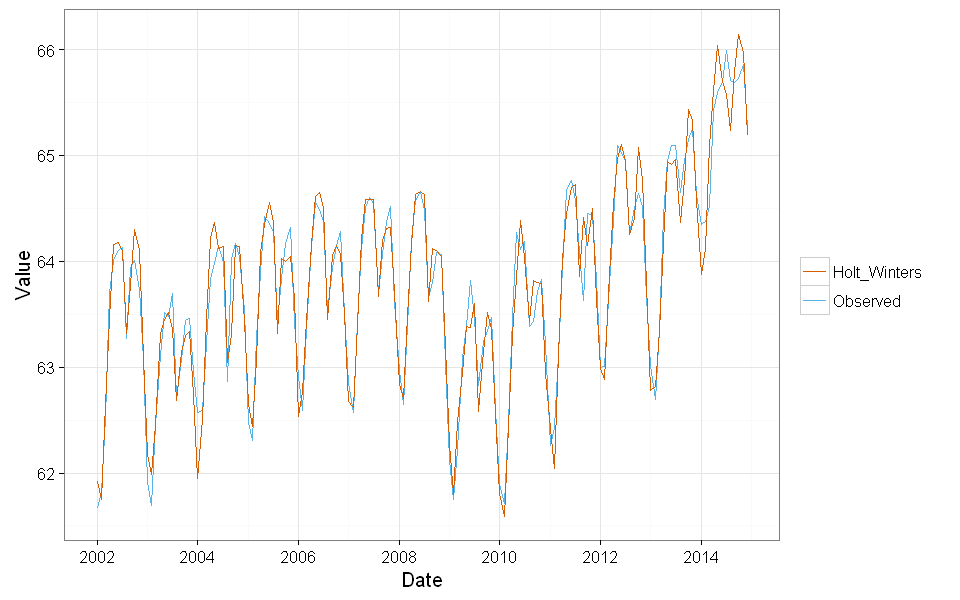

In [4]:
jp_ts <- ts(jp_data$Value, start= 2002, frequency=12)
hw_model <- hw(jp_ts, h = 12, seasonal = "additive", alpha = 0.75, beta = 0.1, gamma = 0.2)
summary(hw_model)
jp_data$HoltWinters_Fit <- hw_model$fitted
jp_data$Resiudals <- jp_data$Value - hw_model$fitted


ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = HoltWinters_Fit, color="Holt_Winters")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Holt_Winters="#D55E00")) +
    theme_bw()

[1] 2.042835

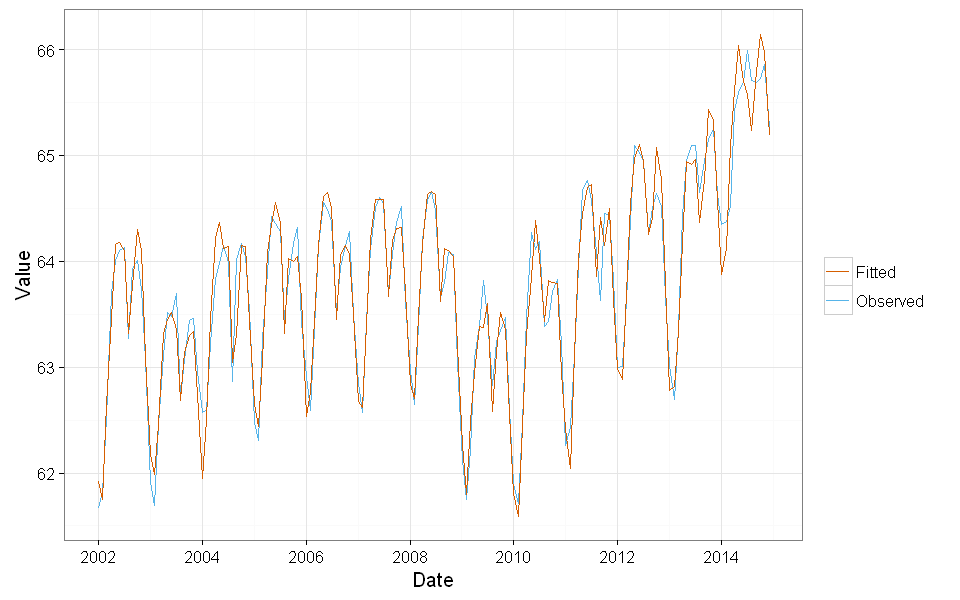

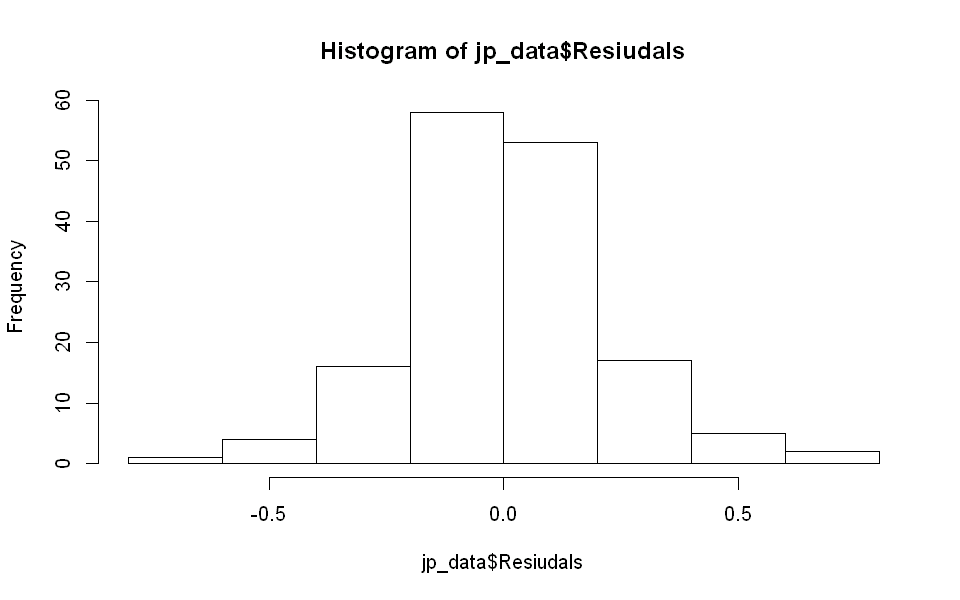

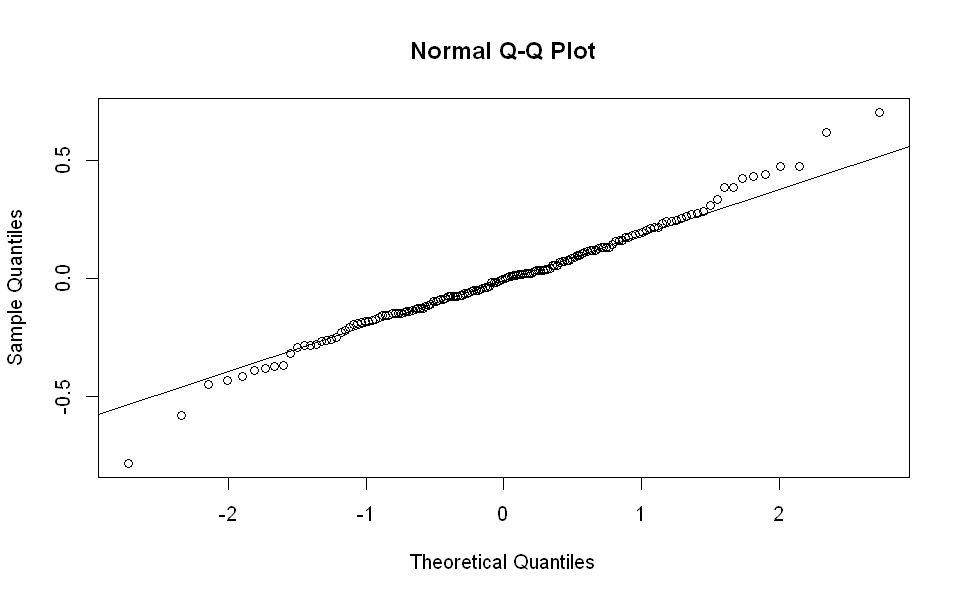

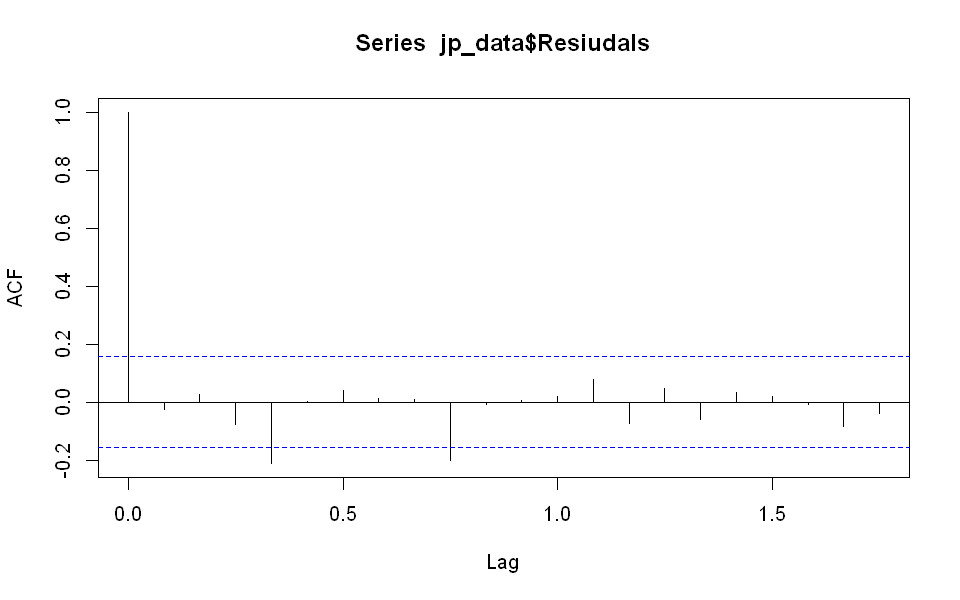

In [5]:
durbinWatsonTest(as.numeric(jp_data$Resiudals))


temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = jp_data$HoltWinters_Fit)
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(jp_data$Resiudals)
qqnorm(jp_data$Resiudals)
qqline(jp_data$Resiudals)
acf(jp_data$Resiudals)

Warning message:
: Removed 12 rows containing missing values (geom_path).

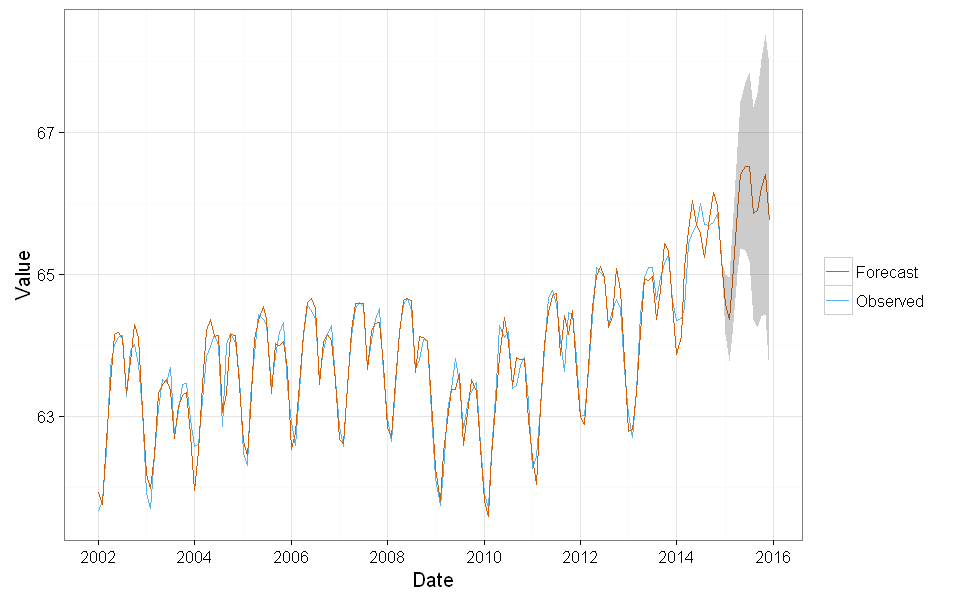

In [19]:
forecast_mean <- hw_model$mean
forecast_high <- hw_model$lower[,2]
forecast_low <- hw_model$upper[,2]

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2015-01-01"), by = "month", length.out = 12)),
                        Value = c(jp_data$Value, rep(NA, 12)),
                        Forecast = c(jp_data$HoltWinters_Fit, forecast_mean),
                        Forecast_low = c(jp_data$HoltWinters_Fit, forecast_low),
                        Forecast_high = c(jp_data$HoltWinters_Fit, forecast_high))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()

In [20]:
holt_winters_forecast <- data.frame(Date = seq(as.Date("2015-01-01"), by = "month", length.out = 12),
                           Low_95 = forecast_low,
                           Mean = forecast_mean,
                           High_95 = forecast_high)

holt_winters_forecast

,Date,Low_95,Mean,High_95
1,2015-01-01,64.99962,64.57354,64.14747
2,2015-02-01,64.95171,64.36403,63.77634
3,2015-03-01,65.63346,64.89487,64.15628
4,2015-04-01,66.78019,65.89385,65.00751
5,2015-05-01,67.43209,66.39805,65.364
6,2015-06-01,67.69679,66.51354,65.33028
7,2015-07-01,67.84585,66.51102,65.17619
8,2015-08-01,67.347,65.85773,64.36846
9,2015-09-01,67.53858,65.89172,64.24486
10,2015-10-01,68.02185,66.21406,64.40627
